## Clustering - Tarea Individual

### Entrega 13/11 a correo marcelo.medel.v@gmail.com.

1 .- (20%) Del código de K-means entregado como ejemplo a continuación, desarrolle: 

* Defina con un nombre cada uno de los segmentos (clusters) encontrados en la data.
* Ejecute el modelo con k=4, ¿cómo se llamaría el nuevo segmento definido?
* ¿Cómo y para qué se utilizan los métodos deSilhouette Score y Calinski Harabrasz?

2 .- (40%) Implemente el código para Hierarchical Agglomerative Clustering (**HAC**), puede reutilizar el código del ejemplo de kaggle. 

* Ejemplo: https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering/notebook
* ¿Cuáles son las principales diferencias entre Single, Complete y Average Linkage en **HAC**?
* ¿Qué tan diferentes son los resultados entre ambos métodos K-means vs HAC?
    * ¿Los clientes quedan categorizados en el mismo cluster u en otro? 
    * ¿Hay diferencias en el tiempo de ejecución?
  
3 .- (40%) Implemente la detección de outliers en el dataframe `rfm` con DBSCAN, siguiendo los ejemplos de los links siguientes. 
* Ejemplo: http://exponentis.es/ejemplo-de-uso-de-dbscan-en-python-para-deteccion-de-outliers
* Ejemplo: https://www.datatechnotes.com/2020/04/anomaly-detection-with-dbscan-in-python.html
* ¿Qué tan diferentes son los resultados respecto a la detección de outliers utilizando ***interquartile range***?

     


# Ejemplo de RFM y K-means

## Data Preprocessing

* Cargamos los datos
* Se eliminan valores nulos
* Se cambia el tipo de datos de customerID
* Se crean nuevos atributos de RFM. 
    * https://medium.com/@hhuseyincosgun/customer-segmentation-rfm-analysis-recency-frequency-monetary-5b29d5d45e35
* Detección y filtraje de outliers para los nuevos atributos creados
* Se realiza un escalamiento de los datos. 


In [5]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import missingno as msno


In [6]:
retail = pd.read_csv('data/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [7]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


<Axes: >

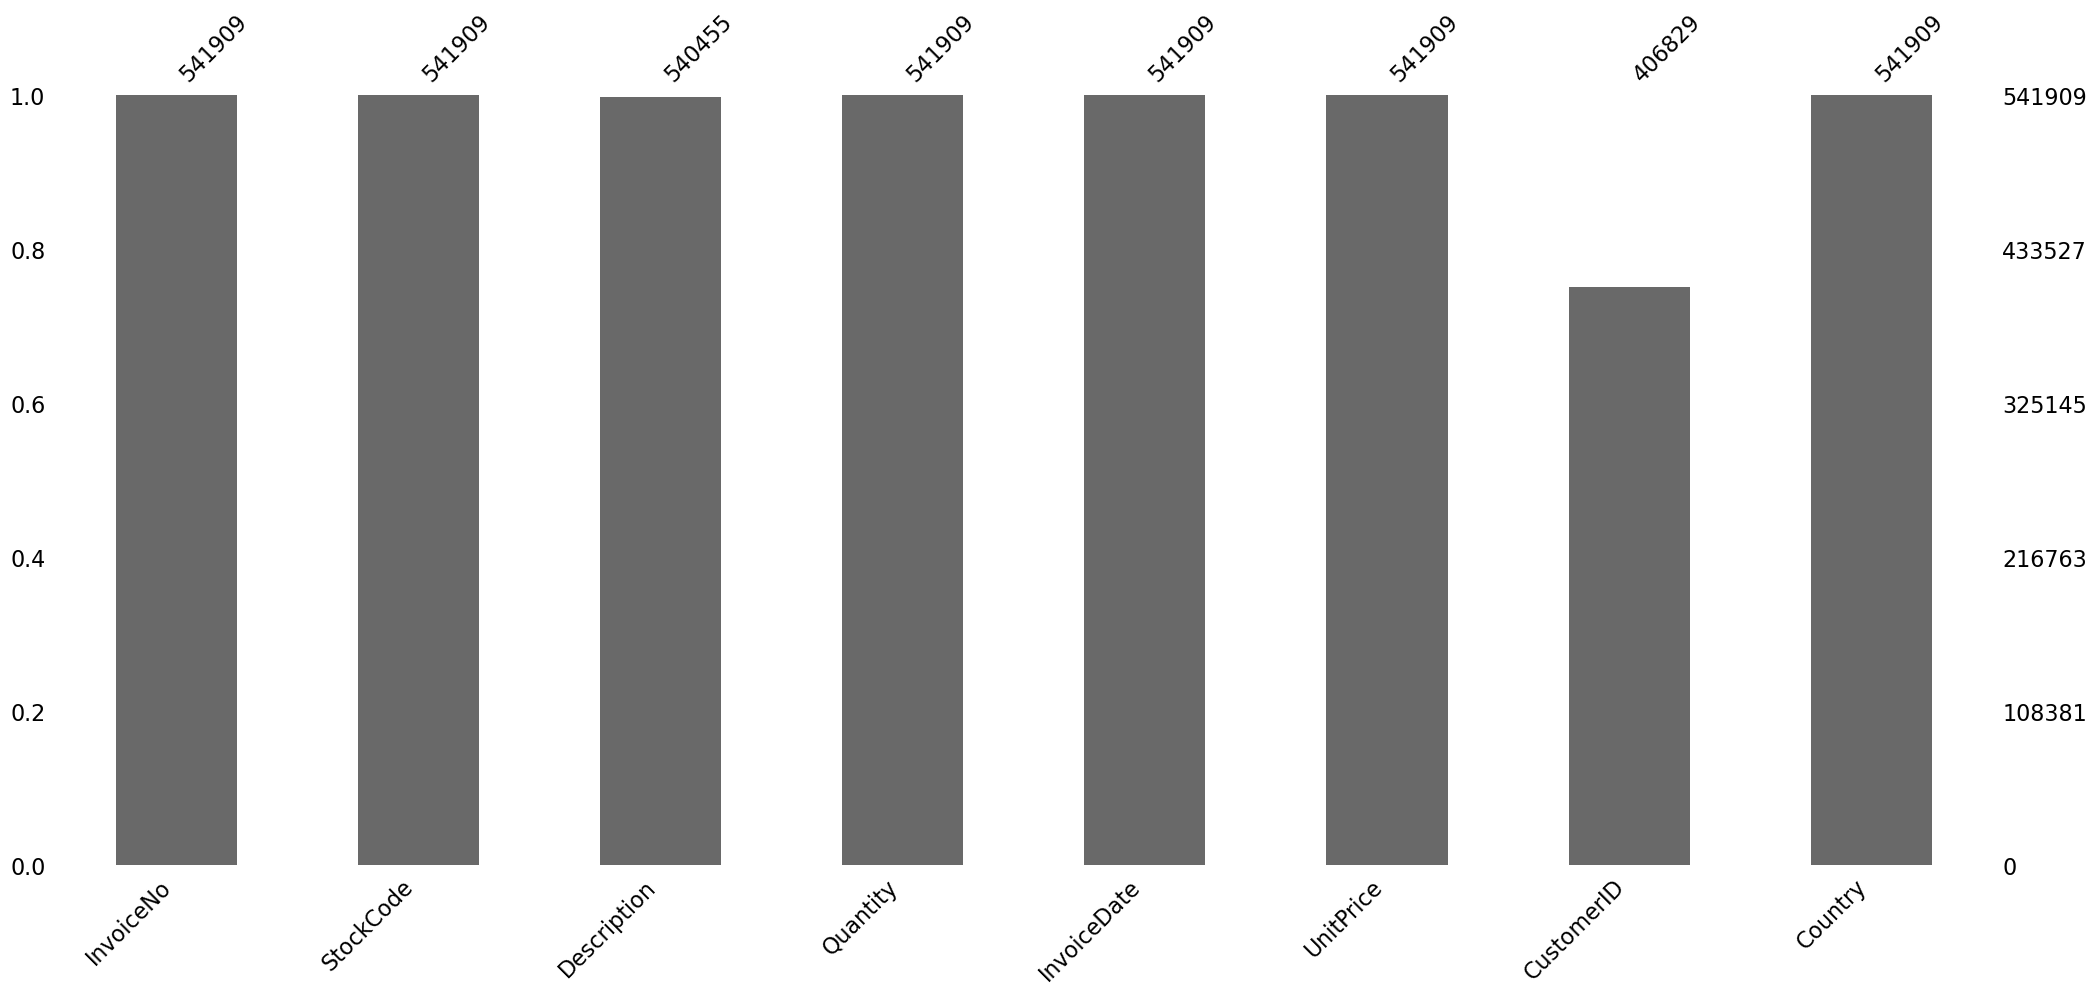

In [8]:
msno.bar(retail)

In [9]:
# Droping rows having missing values
retail = retail.dropna()

# Changing the datatype of Customer Id as per Business understanding
retail['CustomerID'] = retail['CustomerID'].astype(int).astype(str)

retail.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      406829 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.9+ MB


In [10]:
## To do a RFM model we have to create 3 columns recency, frequency and monetary
## monetary = Quantity * UnitPrice

retail.columns = retail.columns.str.lower()
retail['monetary'] = retail['quantity'] * retail['unitprice']
retail['invoicedate'] = pd.to_datetime(retail['invoicedate'],format='%d-%m-%Y %H:%M')
retail['diff_days'] = (retail['invoicedate'].max() - retail['invoicedate']).dt.days

rfm = retail.groupby('customerid').agg({'diff_days': 'min', 'invoiceno':pd.Series.nunique, 'monetary': 'sum' }).reset_index()

rfm.columns = ['customerid', 'recency', 'frequency', 'monetary']

rfm.head()

,customerid,recency,frequency,monetary
0,12346,325,2,0.00
1,12347,1,7,4310.00
2,12348,74,4,1797.24
3,12349,18,1,1757.55
4,12350,309,1,334.40


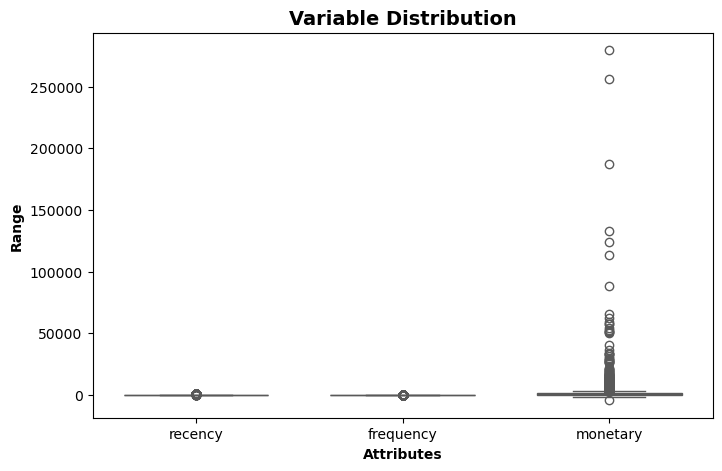

In [11]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['recency','frequency','monetary']
plt.rcParams['figure.figsize'] = [8,5]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.show()

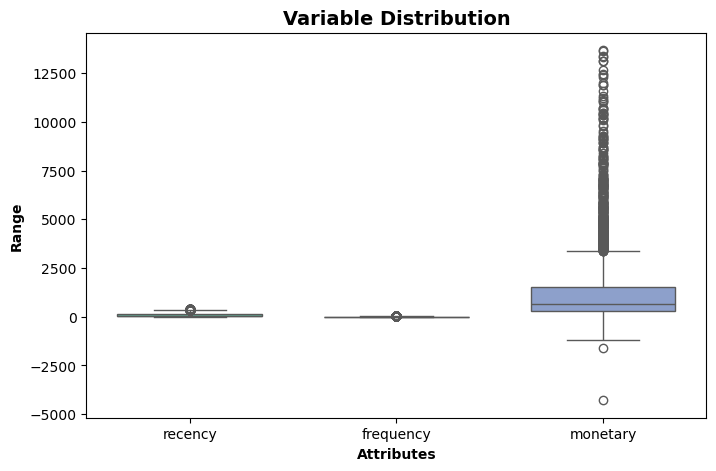

In [12]:
### Outlier Treatment using Interquantile range

def get_iqr(df,col):
    q1 = df[col].quantile(0.05)
    q3 = df[col].quantile(0.95)
    iqr = q3-q1
    return q1,q3,iqr

# Removing (statistical) outliers for Amount
col = 'monetary'
q1, q3, iqr = get_iqr(rfm,col)
rfm = rfm[(rfm[col] >= q1 - 1.5*iqr) & (rfm[col] <= q3 + 1.5*iqr)]

# Removing (statistical) outliers for Recency
col = 'recency'
q1, q3, iqr = get_iqr(rfm,col)
rfm = rfm[(rfm[col] >= q1 - 1.5*iqr) & (rfm[col] <= q1 + 1.5*iqr)]

# Removing (statistical) outliers for Frequency
col = 'frequency'
q1, q3, iqr = get_iqr(rfm,col)
rfm = rfm[(rfm[col] >= q1 - 1.5*iqr) & (rfm[col] <= q3 + 1.5*iqr)]

## ¿cuántos outliers removí?

attributes = ['recency','frequency','monetary']
plt.rcParams['figure.figsize'] = [8,5]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.show()

In [13]:
## Solo dejaremos valores positivos de monetary
rfm = rfm.query('monetary > 0').reset_index(drop=True)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])
scaled.shape

scaled

rfm_scaled = pd.DataFrame(scaled)
rfm_scaled.columns = ['recency', 'frequency', 'monetary']
rfm_scaled.head()

,recency,frequency,monetary
0,-0.903887,0.575435,1.749771
1,-0.168771,-0.063870,0.297362
2,-0.732696,-0.703175,0.274420
3,2.197698,-0.703175,-0.548179
4,-0.561504,1.427842,0.151801


## KMeans

#### Se aplican distintos k con KMeans, se calculan la inercia, distorsión, Silhouette score y Calinski Harabrasz score para cada k.
### 

* https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [11]:
# Calinski Harabasz
from sklearn.metrics import calinski_harabasz_score as chs

# Silhouette score 
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

K = range(2,10)
distortions = []
inertias = []
sil_score = []
chs_score = []

for k in K:
    # intialise kmeans
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(rfm_scaled)
    
    distortions.append(sum(np.min(cdist(rfm_scaled, kmeans.cluster_centers_,
                                    'euclidean'), axis=1)) / rfm_scaled.shape[0])
    inertias.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    sil_score.append(silhouette_score(rfm_scaled, cluster_labels))
    chs_score.append(chs(rfm_scaled,cluster_labels))


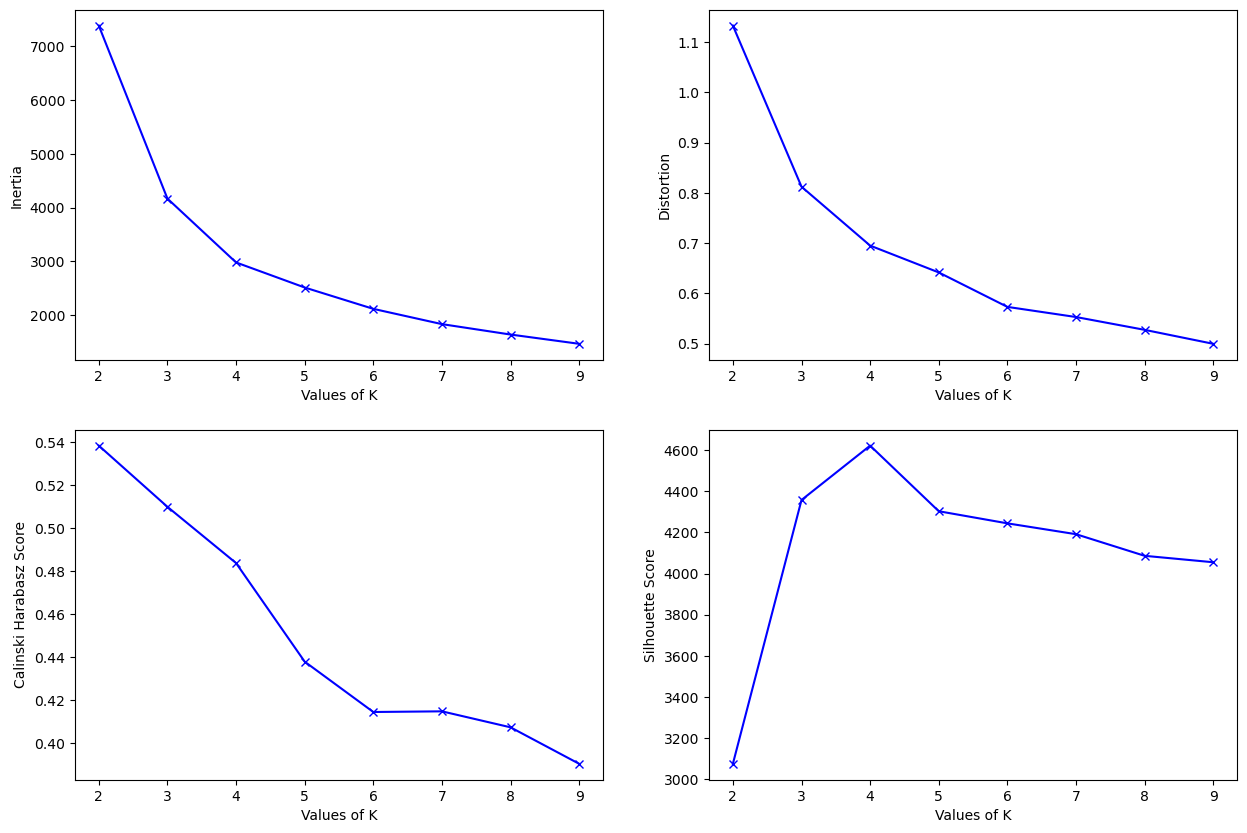

In [12]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
## Plot results

ax[0,0].plot(K, inertias, 'bx-')
ax[0,0].set_xlabel('Values of K')
ax[0,0].set_ylabel('Inertia')

ax[0,1].plot(K, distortions, 'bx-')
ax[0,1].set_xlabel('Values of K')
ax[0,1].set_ylabel('Distortion')

ax[1,0].plot(K, sil_score, 'bx-')
ax[1,0].set_xlabel('Values of K')
ax[1,0].set_ylabel('Calinski Harabasz Score')

ax[1,1].plot(K, chs_score, 'bx-')
ax[1,1].set_xlabel('Values of K')
ax[1,1].set_ylabel('Silhouette Score')

plt.show()

In [13]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_scaled)

KMeans(max_iter=50, n_clusters=3)

In [14]:
# assign the label
rfm['cluster_id'] = kmeans.labels_
rfm.head()

,customerid,recency,frequency,monetary,cluster_id
0,12347,1,7,4310.00,0
1,12348,74,4,1797.24,1
2,12349,18,1,1757.55,1
3,12350,309,1,334.40,2
4,12352,35,11,1545.41,1


### Graficamos los clusters utilizando 2 dimensiones.

* https://www.kaggle.com/dhanyajothimani/basic-visualization-and-clustering-in-python

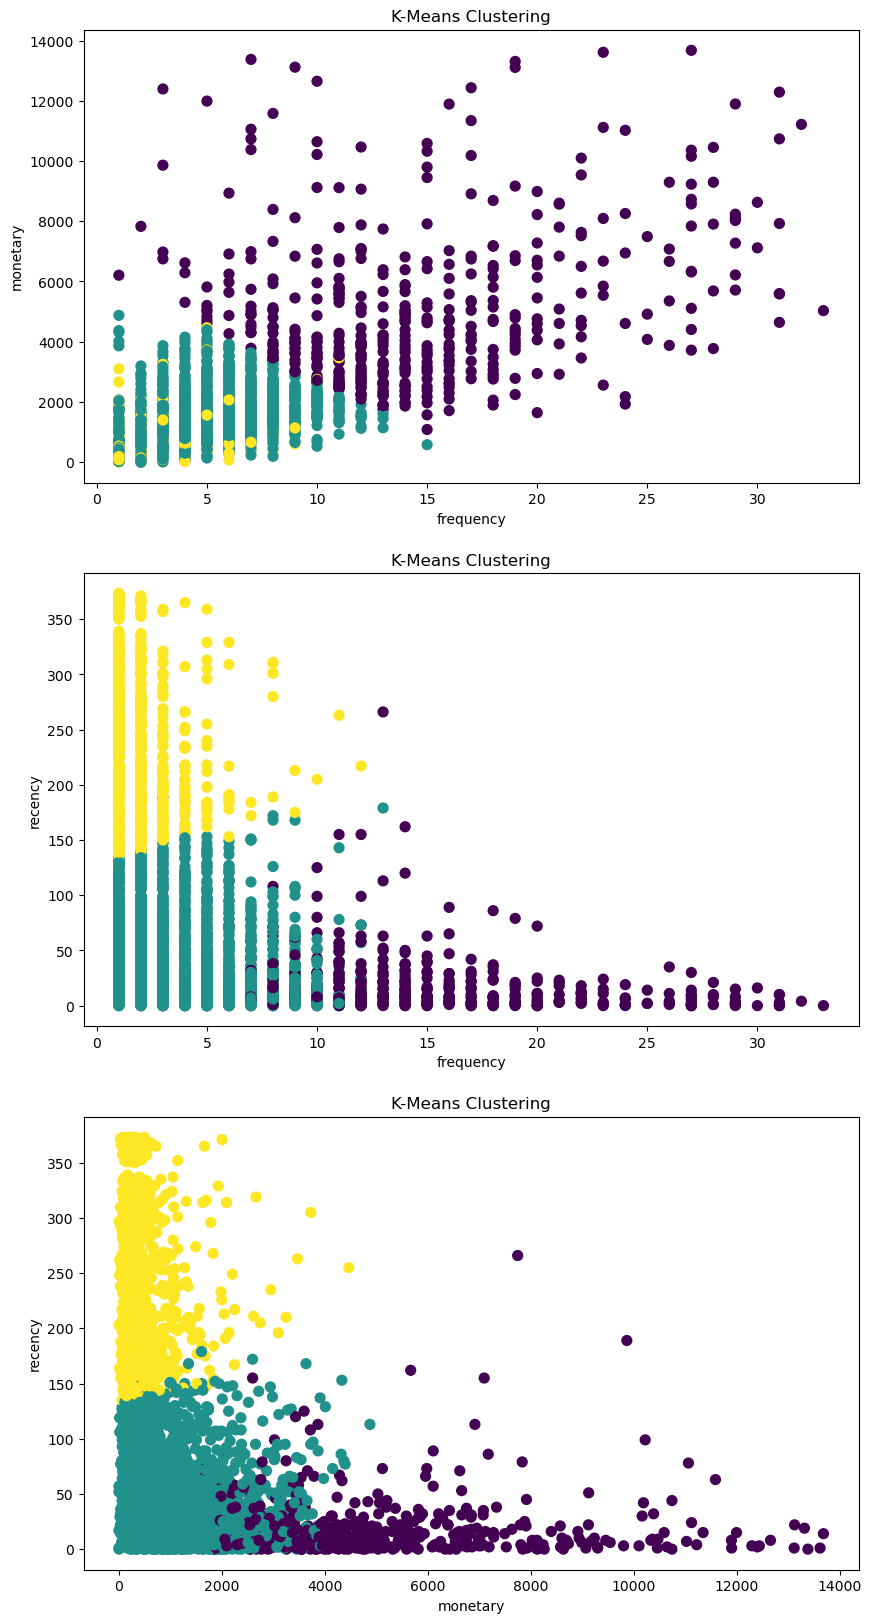

In [15]:
#Plot the clusters obtained using k means

fig, ax = plt.subplots(3,1,figsize=(10,20))
ax[0].scatter(rfm['frequency'],rfm['monetary'],c=rfm['cluster_id'],s=50)
ax[0].set_title('K-Means Clustering')
ax[0].set_xlabel('frequency')
ax[0].set_ylabel('monetary')
#plt.colorbar(scatter)

#Plot the clusters obtained using k means

ax[1].scatter(rfm['frequency'],rfm['recency'],c=rfm['cluster_id'],s=50)
ax[1].set_title('K-Means Clustering')
ax[1].set_xlabel('frequency')
ax[1].set_ylabel('recency')

#Plot the clusters obtained using k means
ax[2].scatter(rfm['monetary'],rfm['recency'],c=rfm['cluster_id'],s=50)
ax[2].set_title('K-Means Clustering')
ax[2].set_xlabel('monetary')
ax[2].set_ylabel('recency')

plt.show()

### Otra forma de visualizar lo mismo

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

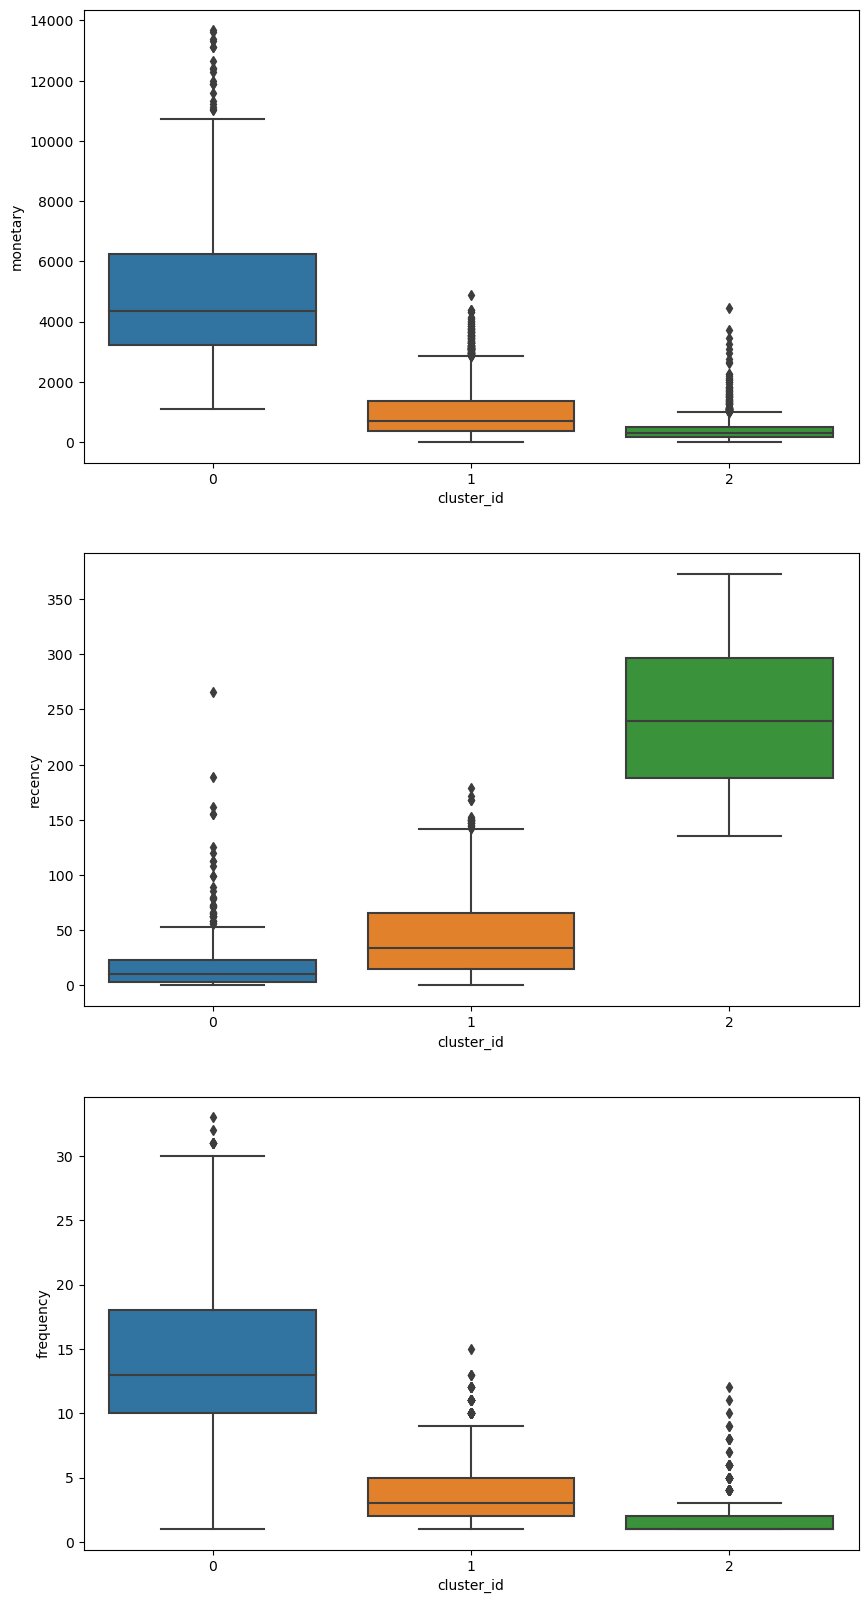

In [16]:
fig, ax = plt.subplots(3,1,figsize=(10,20))

sns.boxplot(x='cluster_id', y='monetary', data=rfm, ax=ax[0])
sns.boxplot(x='cluster_id', y='recency', data=rfm, ax=ax[1])
sns.boxplot(x='cluster_id', y='frequency', data=rfm, ax=ax[2])